In [1]:
# cmdstanr::rebuild_cmdstan();

In [2]:
library(SBC);
library(cmdstanr);
library(jsonlite);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
    dir.create(cache_dir)
}

ALPHA <- 0.05
model_Poisson_1 <- cmdstanr::cmdstan_model("../models/Poisson_model_1.stan")
model_Poisson_2 <- cmdstanr::cmdstan_model("../models/Poisson_model_2.stan")

This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
data_generator_single_Poisson_1 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    force <- force - mean(force)
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    data$home.goals <- rpois(nrow(data), exp(data$Force.x) / exp(data$Force.y))
    data$away.goals <- rpois(nrow(data), exp(data$Force.y) / exp(data$Force.x))
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_goals", "away_goals")

    list(
        variables = list(
            skills = force
        ),
        generated = list(
            num_games = nrow(data),
            num_teams = n_clubs,
            team1 = data$home_name,
            team2 = data$away_name,
            goals_team1 = data$home_goals,
            goals_team2 = data$away_goals
        )
    )
}

In [4]:
data_generator_single_Poisson_2 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    force <- force - mean(force)
    home_force <- rnorm(1)
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    data$home.goals <- rpois(nrow(data), exp(data$Force.x + home_force) / exp(data$Force.y))
    data$away.goals <- rpois(nrow(data), exp(data$Force.y) / exp(data$Force.x + home_force))
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_goals", "away_goals")

    list(
        variables = list(
            skills = force,
            home_force = home_force
        ),
        generated = list(
            num_games = nrow(data),
            num_teams = n_clubs,
            team1 = data$home_name,
            team2 = data$away_name,
            goals_team1 = data$home_goals,
            goals_team2 = data$away_goals
        )
    )
}

In [5]:
set.seed(0)
n_sims <- 250
data_generator_Poisson_1 <- SBC_generator_function(data_generator_single_Poisson_1, n_clubs = 20)
dataset_Poisson_1 <- generate_datasets(data_generator_Poisson_1, n_sims)
backend_Poisson_1 <- SBC_backend_cmdstan_sample(model_Poisson_1, iter_warmup = 2000,
                                                iter_sampling = 2500, chains = 4)

results_Poisson_1 <- compute_SBC(dataset_Poisson_1, backend_Poisson_1,
                                 cache_mode = "results",
                                 cache_location = file.path(cache_dir, "results_Poisson_1"))
    
write.csv(results_Poisson_1$stats,
          file = "SBC_cache/results_Poisson_1.csv")

Cache file exists but the datasets hash differs. Will recompute.



In [6]:
set.seed(0)
n_sims <- 250
data_generator_Poisson_2 <- SBC_generator_function(data_generator_single_Poisson_2, n_clubs = 20)
dataset_Poisson_2 <- generate_datasets(data_generator_Poisson_2, n_sims)
backend_Poisson_2 <- SBC_backend_cmdstan_sample(model_Poisson_2, iter_warmup = 2000,
                                                iter_sampling = 2500, chains = 4)

results_Poisson_2 <- compute_SBC(dataset_Poisson_2, backend_Poisson_2,
                                 cache_mode = "results",
                                 cache_location = file.path(cache_dir, "results_Poisson_2"))
    
write.csv(results_Poisson_2$stats,
          file = "SBC_cache/results_Poisson_2.csv")

Cache file exists but the datasets hash differs. Will recompute.



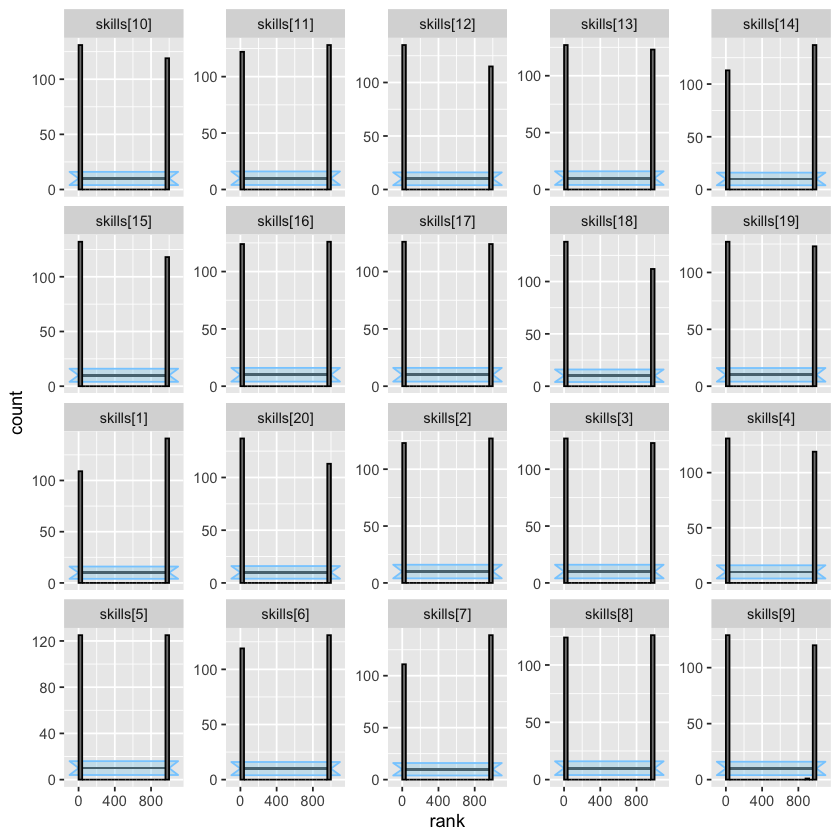

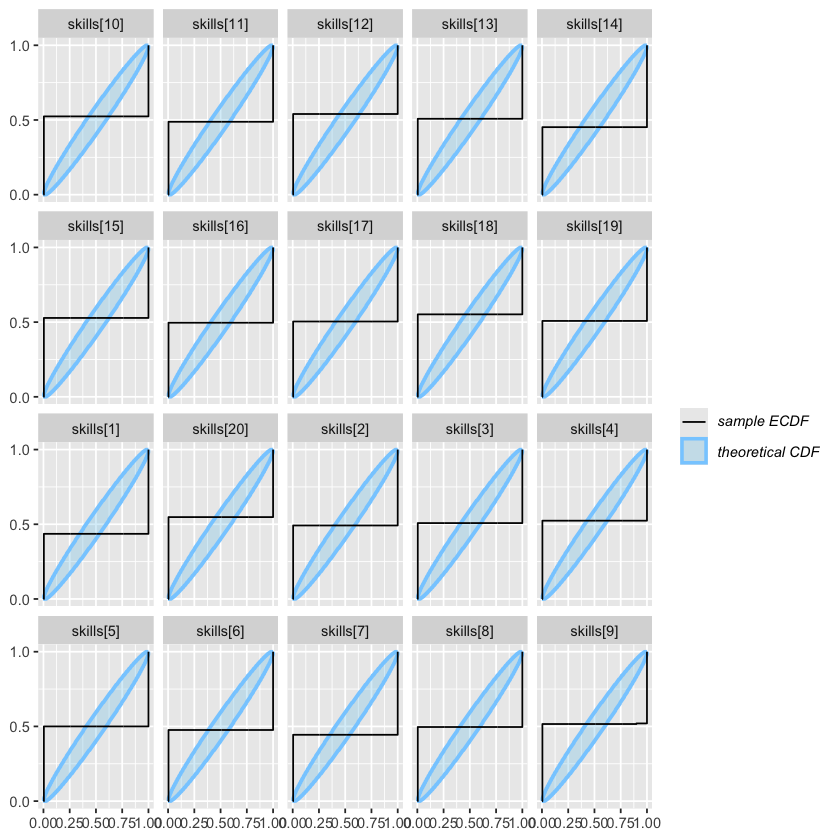

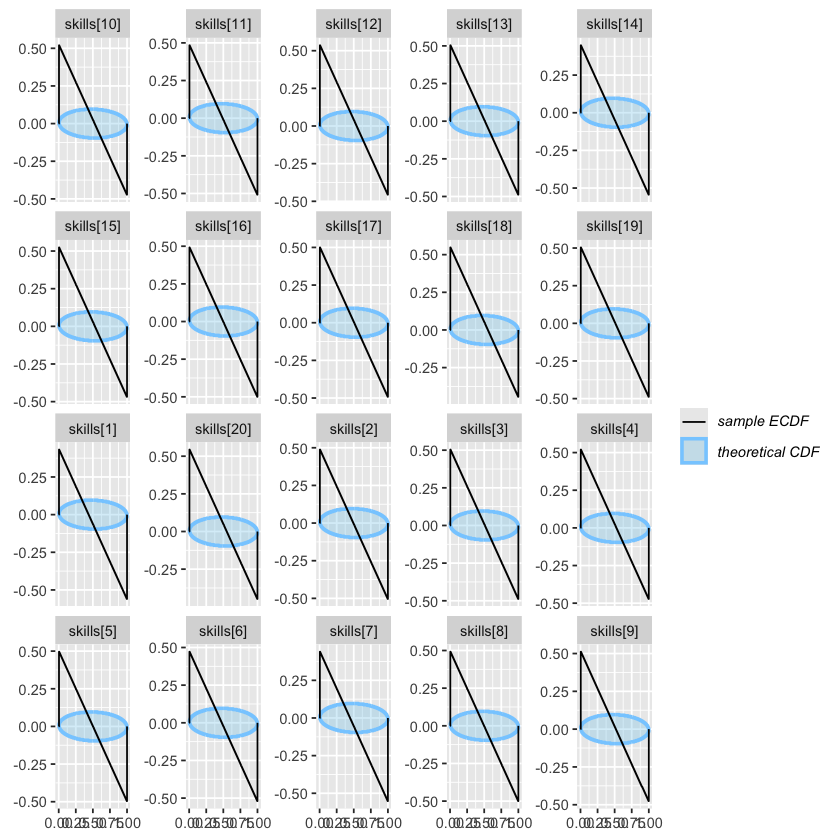

In [7]:
plot_rank_hist(results_Poisson_1)
plot_ecdf(results_Poisson_1)
plot_ecdf_diff(results_Poisson_1)

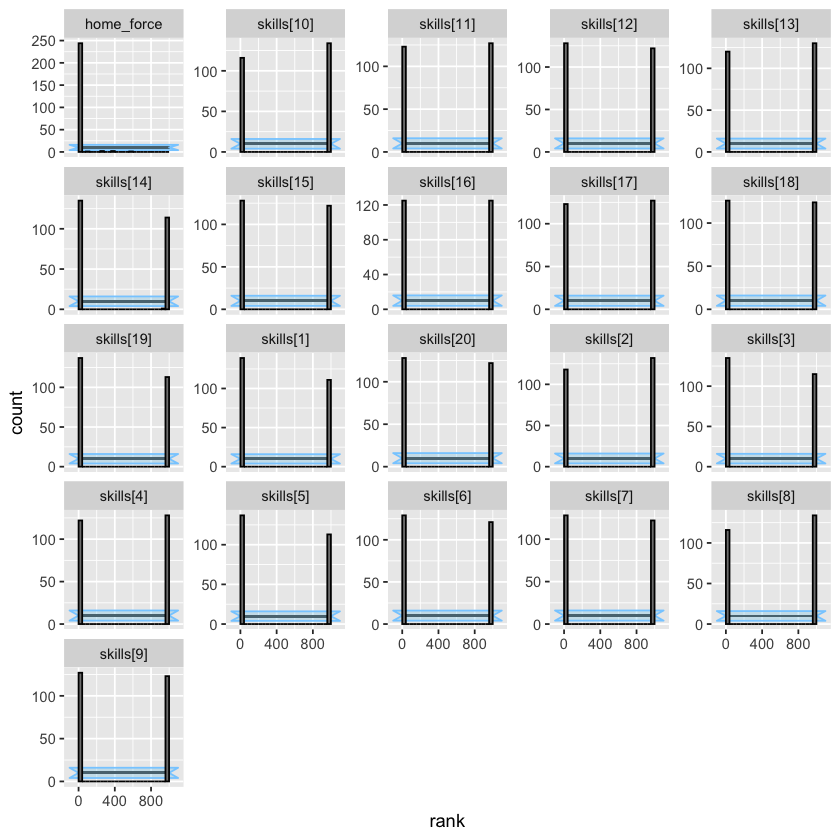

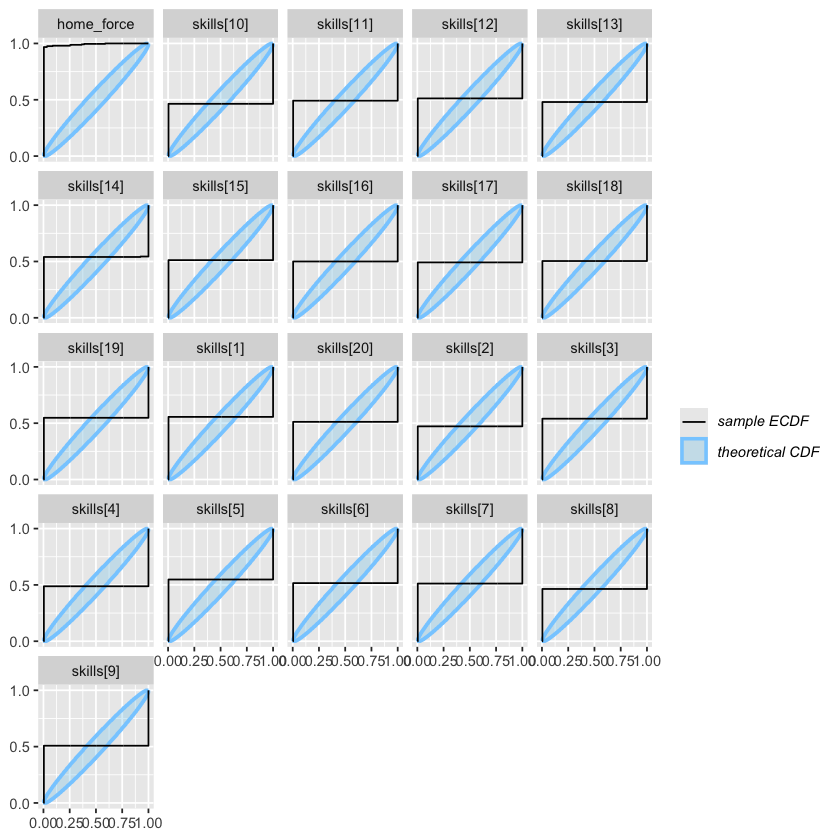

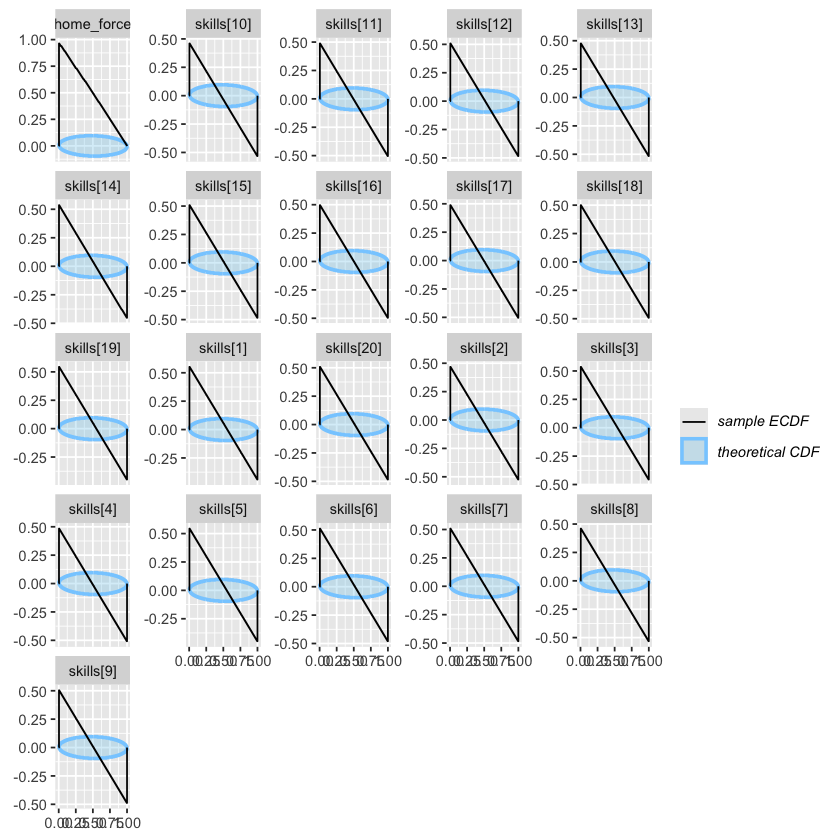

In [8]:
plot_rank_hist(results_Poisson_2)
plot_ecdf(results_Poisson_2)
plot_ecdf_diff(results_Poisson_2)

In [9]:
results <- results_Poisson_1
graph <- plot_ecdf(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
df1$out <- df1$out_ratio > ALPHA

graph <- plot_ecdf_diff(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
df2$out <- df2$out_ratio > ALPHA

final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.


[1] 1 1

In [10]:
results <- results_Poisson_2
graph <- plot_ecdf(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out), .groups = 'keep')
df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
df1$out <- df1$out_ratio > ALPHA

graph <- plot_ecdf_diff(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
df2$out <- df2$out_ratio > ALPHA

final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.


[1] 1 1

In [11]:
data <- read_json('../real_data/Poisson_model_data_2023.json')
data$teams <- NULL

fit_Poisson_1 <- model_Poisson_1$sample(
  data = data,
  chains = 4,
  parallel_chains = 4,
  refresh = 500
)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iterati

In [12]:
fit_Poisson_1$summary(
  variables = NULL,
  posterior::default_summary_measures(),
  extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-9.956877e+02,-9.953105e+02,3.555551e+00,3.547862e+00,-1.002031e+03,-9.905738e+02,-1.003410e+03,-9.899257e+02
skills[1],2.220975e-05,1.613965e-05,2.102384e-05,1.604809e-05,1.252185e-06,6.491322e-05,5.681829e-07,7.881267e-05
skills[2],2.242475e-05,1.612540e-05,2.136926e-05,1.624827e-05,1.301296e-06,6.584510e-05,7.126563e-07,7.817513e-05
skills[3],2.210322e-05,1.490765e-05,2.208794e-05,1.567634e-05,1.298972e-06,6.649905e-05,7.237172e-07,8.144788e-05
skills[4],2.238314e-05,1.514725e-05,2.243342e-05,1.556285e-05,1.213309e-06,6.675298e-05,7.199894e-07,8.236604e-05
skills[5],2.211544e-05,1.544330e-05,2.189267e-05,1.620348e-05,1.031267e-06,6.685253e-05,5.357367e-07,8.067800e-05
skills[6],2.199188e-05,1.542145e-05,2.186006e-05,1.568160e-05,1.099556e-06,6.608038e-05,4.968165e-07,8.079994e-05
skills[7],2.191804e-05,1.555280e-05,2.130049e-05,1.627661e-05,1.037401e-06,6.513228e-05,5.392893e-07,7.951422e-05
skills[8],2.220876e-05,1.529750e-05,2.148161e-05,1.603404e-05,1.176169e-06,6.619917e-05,6.278737e-07,7.820053e-05


In [13]:
data <- read_json('../real_data/Poisson_model_data_2023.json')
data$teams <- NULL

fit_Poisson_2 <- model_Poisson_2$sample(
  data = data,
  chains = 4,
  parallel_chains = 4,
  refresh = 500
)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iterati

In [14]:
fit_Poisson_2$summary(
  variables = NULL,
  posterior::default_summary_measures(),
  extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-9.866419e+02,-9.863655e+02,3.736489e+00,3.734669e+00,-9.932840e+02,-9.811888e+02,-9.946226e+02,-9.804957e+02
skills[1],2.139254e-05,1.479525e-05,2.105812e-05,1.547192e-05,1.031741e-06,6.252988e-05,5.841377e-07,7.702576e-05
skills[2],2.176007e-05,1.532690e-05,2.135914e-05,1.564862e-05,1.078748e-06,6.322858e-05,5.403246e-07,7.741350e-05
skills[3],2.245582e-05,1.580780e-05,2.150774e-05,1.612566e-05,1.236351e-06,6.470537e-05,6.368970e-07,7.873075e-05
skills[4],2.265562e-05,1.538200e-05,2.237703e-05,1.626408e-05,1.242376e-06,6.826681e-05,6.905067e-07,8.466434e-05
skills[5],2.192947e-05,1.515105e-05,2.174674e-05,1.565237e-05,1.052843e-06,6.567753e-05,4.872509e-07,8.048686e-05
skills[6],2.239936e-05,1.582560e-05,2.204606e-05,1.628884e-05,1.135400e-06,6.644288e-05,6.330496e-07,8.194711e-05
skills[7],2.210986e-05,1.548970e-05,2.199725e-05,1.595263e-05,1.115113e-06,6.541856e-05,6.035911e-07,8.251470e-05
skills[8],2.221288e-05,1.557675e-05,2.167691e-05,1.602516e-05,1.255382e-06,6.684197e-05,7.802198e-07,8.036853e-05
